# Paraphrase Detection Model
MSRP Corpus

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import datetime, time, json
from keras.models import Sequential, Model
from keras.layers import Input, Embedding, Dense, Dropout, concatenate, LSTM
from keras.callbacks import Callback, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.callbacks import TensorBoard
from keras.layers.wrappers import Bidirectional
from keras.utils import plot_model

In [ ]:
# Initialize global variables
S1_TRAINING_DATA_FILE = '/content/drive/MyDrive/ParaphraseDetection/paraphrase4/s1_train.npy'
S2_TRAINING_DATA_FILE = '/content/drive/MyDrive/ParaphraseDetection/paraphrase4/s2_train.npy'
LABEL_TRAINING_DATA_FILE = '/content/drive/MyDrive/ParaphraseDetection/paraphrase4/label_train.npy'
WORD_EMBEDDING_MATRIX_FILE = '/content/drive/MyDrive/ParaphraseDetection/paraphrase4/word_embedding_matrix.npy'
NUM_WORDS_DATA_FILE = '/content/drive/MyDrive/ParaphraseDetection/paraphrase4/num_words.json'
MAX_NUM_WORDS = 20000
MAX_SEQUENCE_LENGTH = 30
EMBEDDING_DIM = 200
MODEL_WEIGHTS_FILE = '/content/drive/MyDrive/ParaphraseDetection/paraphrase4/model.h5'
VALIDATION_SPLIT = 0.2
TEST_SPLIT = 0.2
RNG_SEED = 13371447
NUM_EPOCHS = 25
DROPOUT = 0.2
BATCH_SIZE = 32
OPTIMIZER = 'adadelta'
HIDDEN_SIZE = 50

In [ ]:
# Load the dataset, embedding matrix and word count

s1_data = np.load(open(S1_TRAINING_DATA_FILE, 'rb'))
s2_data = np.load(open(S2_TRAINING_DATA_FILE, 'rb'))
labels = np.load(open(LABEL_TRAINING_DATA_FILE, 'rb'))
word_embedding_matrix = np.load(open(WORD_EMBEDDING_MATRIX_FILE, 'rb'))

with open(NUM_WORDS_DATA_FILE, 'r') as f:
    num_words = json.load(f)['num_words']

In [ ]:
print('Shape of sentence data:', s1_data.shape)
print('Shape of label data:',labels.shape)



Shape of sentence data: (5800, 30)
Shape of label data: (5800,)


 # Divide the data into train and test set

In [ ]:
# Divide the dataset into train and test sets
X = np.stack((s1_data, s2_data), axis=1)
y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SPLIT, random_state=RNG_SEED)

s1_train = X_train[:,0]
s2_train = X_train[:,1]

s1_test = X_test[:,0]
s2_test = X_test[:,1]
print(s1_test)

[[    0     0 11197 ...    80 14049   671]
 [    0     0     0 ...     2    23  8142]
 [    0     0     0 ...     4   440   385]
 ...
 [    0     0     0 ...   451   150     7]
 [    0     0     0 ...  9659    52   127]
 [    0     0     0 ...    17   550   630]]


# Define the model

In [ ]:
# define the model
sentence1 = Input(shape=(MAX_SEQUENCE_LENGTH,))
sentence2 = Input(shape=(MAX_SEQUENCE_LENGTH,))

s1 = Embedding(num_words + 1, 
                 EMBEDDING_DIM, 
                 weights=[word_embedding_matrix], 
                 input_length=MAX_SEQUENCE_LENGTH, 
                 trainable=True)(sentence1)
s1 = Bidirectional(LSTM(HIDDEN_SIZE, dropout=0.2, recurrent_dropout=0.2))(s1)

In [ ]:
s2 = Embedding(num_words + 1, 
                 EMBEDDING_DIM, 
                 weights=[word_embedding_matrix], 
                 input_length=MAX_SEQUENCE_LENGTH, 
                 trainable=True)(sentence2)
s2 = Bidirectional(LSTM(HIDDEN_SIZE, dropout=0.2, recurrent_dropout=0.2))(s2)

In [ ]:
merged = concatenate([s1,s2])

is_paraphrase = Dense(1, activation='sigmoid')(merged)

model = Model(inputs=[sentence1,sentence2], outputs=is_paraphrase)
model.compile(loss='binary_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy'])


In [ ]:
tensorboard  = TensorBoard(log_dir='./Graph', 
                                          histogram_freq=0,
                                          write_graph=True, 
                                          write_images=True)

In [ ]:
# Train the model, checkpointing weights with best validation accuracy
print("Starting training at", datetime.datetime.now())
t0 = time.time()
callbacks = [ModelCheckpoint(MODEL_WEIGHTS_FILE, monitor='val_acc', save_best_only=True), tensorboard]

history = model.fit([s1_train, s2_train],
                    y_train,
                    epochs=NUM_EPOCHS,
                    validation_split=VALIDATION_SPLIT,
                    verbose=2,
                    shuffle=True,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks)
t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2021-04-28 11:03:46.138609
Epoch 1/25
116/116 - 29s - loss: 0.6692 - accuracy: 0.6258 - val_loss: 0.6721 - val_accuracy: 0.6067
Epoch 2/25
116/116 - 20s - loss: 0.6662 - accuracy: 0.6371 - val_loss: 0.6683 - val_accuracy: 0.6282
Epoch 3/25
116/116 - 20s - loss: 0.6633 - accuracy: 0.6444 - val_loss: 0.6647 - val_accuracy: 0.6466
Epoch 4/25
116/116 - 20s - loss: 0.6604 - accuracy: 0.6476 - val_loss: 0.6614 - val_accuracy: 0.6509
Epoch 5/25
116/116 - 20s - loss: 0.6561 - accuracy: 0.6560 - val_loss: 0.6584 - val_accuracy: 0.6552
Epoch 6/25
116/116 - 20s - loss: 0.6544 - accuracy: 0.6546 - val_loss: 0.6555 - val_accuracy: 0.6595
Epoch 7/25
116/116 - 20s - loss: 0.6521 - accuracy: 0.6557 - val_loss: 0.6529 - val_accuracy: 0.6606
Epoch 8/25
116/116 - 20s - loss: 0.6499 - accuracy: 0.6603 - val_loss: 0.6505 - val_accuracy: 0.6627
Epoch 9/25
116/116 - 20s - loss: 0.6475 - accuracy: 0.6657 - val_loss: 0.6484 - val_accuracy: 0.6692
Epoch 10/25
116/116 - 20s - loss: 0.6449 - 

In [ ]:
# Print best validation accuracy and epoch
model.save_weights("/content/drive/MyDrive/ParaphraseDetection/paraphrase4/model.h5")
max_val_acc, idx = max((val, idx) for (idx, val) in enumerate(history.history['val_accuracy']))
print('Maximum validation accuracy = {0:.4f} (epoch {1:d})'.format(max_val_acc, idx+1))

# Evaluate the model with best validation accuracy on the test partition
model.load_weights(MODEL_WEIGHTS_FILE)
print(s1_test)
loss, accuracy = model.evaluate([s1_test, s2_test], y_test, verbose=0)
print('Test loss = {0:.4f}, test accuracy = {1:.4f}'.format(loss, accuracy))

Maximum validation accuracy = 0.6756 (epoch 13)
[[    0     0 11197 ...    80 14049   671]
 [    0     0     0 ...     2    23  8142]
 [    0     0     0 ...     4   440   385]
 ...
 [    0     0     0 ...   451   150     7]
 [    0     0     0 ...  9659    52   127]
 [    0     0     0 ...    17   550   630]]
Test loss = 0.6834, test accuracy = 0.5733


In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

s1 = "Harry Potter defeated Voldemort"
s2 = "Voldemort was defeated by Harry Potter"
MAX_SEQUENCE_LENGTH = 30

sentences = s1 + s2
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(sentences)
sentence1_word_sequences = tokenizer.texts_to_sequences(s1)
sentence2_word_sequences = tokenizer.texts_to_sequences(s2)

s1_dt = pad_sequences(sentence1_word_sequences, maxlen=MAX_SEQUENCE_LENGTH)
s2_dt = pad_sequences(sentence2_word_sequences, maxlen=MAX_SEQUENCE_LENGTH)
print(y_test)
y = model.predict([s1_test,s2_test])
count = 0
# print(y.type())
for x in y:
  if x < 0.5:
    print(s1_test[count])
    print(s2_test[count])
    print("No WE not PARAPHRASE")
  count += 1
print(count)

[1 1 1 ... 1 1 1]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    1  107  176   74  506   92 1258   25   63  108   15    2   23
 7834 1105]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    1  107  176   74  683    3  191  797   11 4651   45  263
  180   68]
No WE not PARAPHRASE
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    5  345 1251   15 2595  167  957   45   18 1218   15    4
   34  216]
[   0    0    0    0    0    0    0    0    0    0   17  345  364 1251
   15    3 1918  919 2595  591  957 7740  400   14  332   15  591  545
   50 2431]
No WE not PARAPHRASE
[    0     0     0     0     0     0     0     0     0     0     0     0
  1182   412    89     1  3035   521    82    29 13800   305   922   301
     3     4   628   253     5  2077]
[   0    0    0    0    0    0    0    0    0    0    0    0   60 1182
 1193 3035  491    5 2077   37    1  278  491  305  922  301    3    

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 200)      3307600     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 30, 200)      3307600     input_2[0][0]                    
______________________________________________________________________________________________

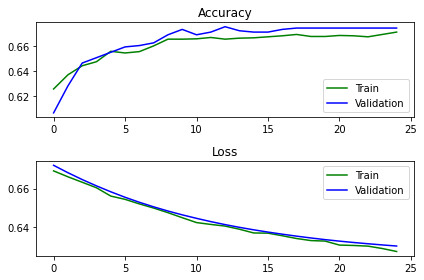

In [ ]:
# Plot the loss and accuracy values over time 
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["accuracy"], color="g", label="Train")
plt.plot(history.history["val_accuracy"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="Train")
plt.plot(history.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

# Print best validation accuracy and epoch

In [ ]:
max_val_acc, idx = max((val, idx) for (idx, val) in enumerate(history.history['val_accuracy']))
print('Maximum accuracy at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(max_val_acc))

Maximum accuracy at epoch 13 = 0.6756


# Evaluate the model with best validation accuracy on the test partition

In [ ]:
# model.load_weights(MODEL_WEIGHTS_FILE)
loss, accuracy = model.evaluate([s1_test, s2_test], y_test, verbose=0)
print('loss = {0:.4f}, accuracy = {1:.4f}'.format(loss, accuracy))

loss = 0.6834, accuracy = 0.5733


# Save graph of model to a file

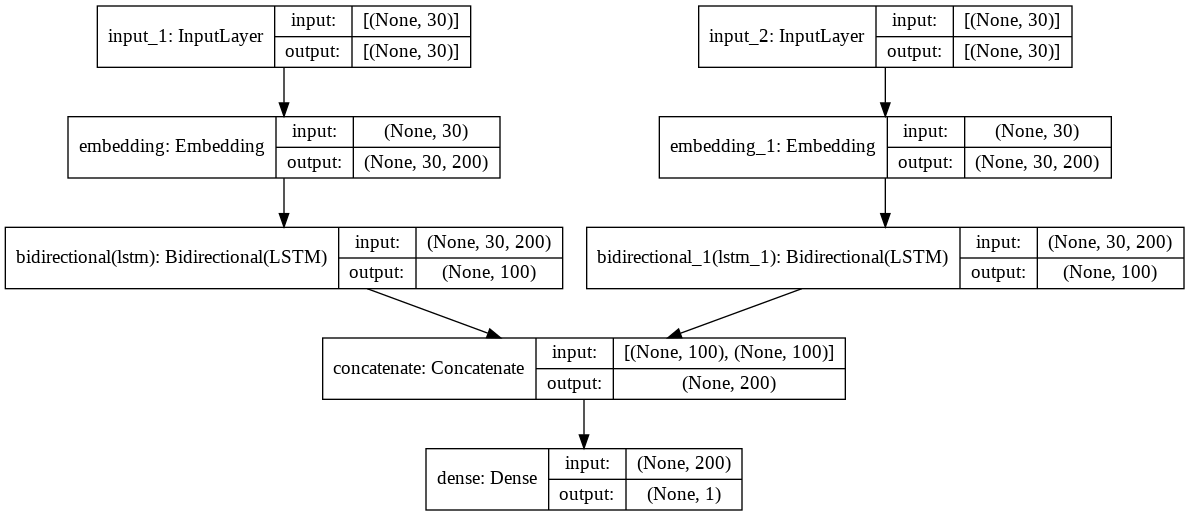

In [ ]:
plot_model(model, to_file='paraphrase-model.png', show_shapes=True)


<img src="paraphrase-model.png">